In [2]:
import glob, os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow

from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, Activation, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping


tensorflow.logging.set_verbosity(tensorflow.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


# DenseNet 성능 확인
## 데이터 불러오기

In [6]:
food_list = ['갈비구이', '제육볶음', '짬뽕', '삼겹살', '짜장면', '삼계탕', '불고기', '곰탕_설렁탕', '칼국수', '훈제오리']

In [7]:
## 사진 사이즈 변경해서 np array로 변경

image_folder = 'top10_food_test'
img_path = image_folder + '/'
image_size = 32

x_test = []
y_test = []

print('test 이미지 입력')

for i, food in enumerate(food_list):
    path = img_path + food  
    print(food, end = ',')

    files = []
    files.extend(glob.glob(path + '/*'))

    for file in files:
        img = Image.open(file)
        img = img.convert("RGB") # 색상 모드 변경
        img = img.resize((image_size, image_size)) # 이미지 크기 변경

        data = np.asarray(img)

        x_test.append(data)
        y_test.append(i)
        
print()

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

test 이미지 입력
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [8]:
x_test = np.array(x_test) / 127.5 - 1

In [9]:
y_test_reshape = y_test.reshape(-1, 1)

# DenseNet - Image size:32, Epoch:50

### train acc
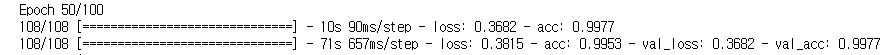

In [10]:
datagen = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True )

# hyperparameters
K = 32
init_ch = 64 # 가장 첫 layer의 채널 수 입니다.
compression = 0.5 # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5 사용

inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)


def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)

        x = concatenate([x, tmp])

    return x


def transition_block(x):
    shape = x.get_shape().as_list() # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression) # compression 비율만큼 channel을 줄여 줍니다.

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))


input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)
x = dense_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(30, activation='softmax')(x)

dense = Model(input_img, x)

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5',
                             save_best_only=True,
                             save_weights_only=True)

In [11]:
dense.compile(optimizer=Adam(0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
x_test[0]

array([[[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 0.99215686,  0.97647059,  0.98431373],
        ...,
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 0.81176471,  0.89019608,  0.90588235],
        [ 0.82745098,  0.90588235,  0.92156863],
        ...,
        [ 0.83529412,  0.89803922,  0.92156863],
        [ 0.82745098,  0.89019608,  0.91372549],
        [ 1.        ,  0.98431373,  1.        ]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 0.81960784,  0.89803922,  0.91372549],
        [ 0.82745098,  0.90588235,  0.92156863],
        ...,
        [ 0.83529412,  0.89803922,  0.92156863],
        [ 0.82745098,  0.89019608,  0.91372549],
        [ 1.        ,  0.99215686,  1.        ]],

       ...,

       [[ 0.96862745,  0.98431373,  0.97647059],
        [ 0

In [26]:
model_filename = "h_file/model_50.h5"

dense.load_weights(model_filename)

predicted = [np.argmax(i) for i in dense.predict(x_test)]

In [27]:
score = dense.evaluate(x_test, y_test_reshape)

100/100 [==============================] - 4s 38ms/sample - loss: 3.0945 - acc: 0.5200


In [28]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test[i]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test[i]], end='')
        
    if food_list[predicted[i]] == food_list[y_test[i]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

예측: 불고기		/	실제 값: 갈비구이
예측: 짜장면		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 삼겹살		/	실제 값: 갈비구이

예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짬뽕		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짜장면		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짬뽕		/	실제 값: 제육볶음

예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 삼겹살		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 갈비구이		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 제육볶음		/	실제 값: 짬뽕

예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 불고기		/	실제 값: 삼겹살
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹

# DenseNet - Image size:32, Epoch:100
## train acc
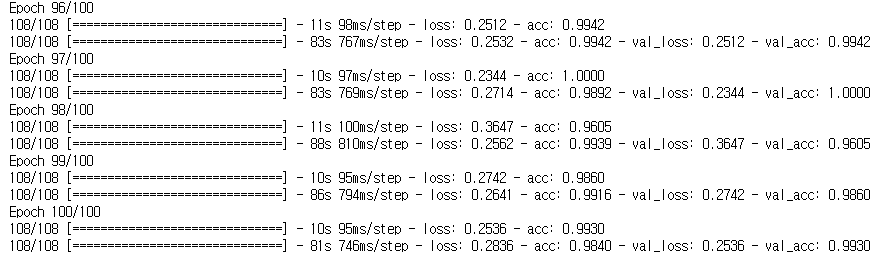

In [12]:
model_filename = "h_file/denseNet_top10_food.h5"
dense.load_weights(model_filename)

predicted = [np.argmax(i) for i in dense.predict(x_test)]

In [13]:
score = dense.evaluate(x_test, y_test_reshape)

100/100 [==============================] - 3s 35ms/sample - loss: 2.2571 - acc: 0.5900


In [31]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test[i]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test[i]], end='')
        
    if food_list[predicted[i]] == food_list[y_test[i]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

예측: 불고기		/	실제 값: 갈비구이
예측: 짜장면		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 삼겹살		/	실제 값: 갈비구이

예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짜장면		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짬뽕		/	실제 값: 제육볶음

예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 훈제오리		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 훈제오리		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕

예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 불고기		/	실제 값: 삼겹살
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값

In [14]:
food_endict = {'갈비구이' : 'Galbigu-i', 
               '곰탕_설렁탕' : 'Gomtang_Seolleongtang', 
               '불고기' : 'Bulgogi', 
               '삼겹살' : 'Samgyeobsal', 
               '삼계탕' : 'Samgyetang', 
               '제육볶음' : 'Jeyugbokk-eum', 
               '짜장면' : 'Jjajangmyeon', 
               '짬뽕' : 'Jjamppong', 
               '칼국수' : 'Kalgugsu', 
               '훈제오리' : 'Hunje-oli'}

In [15]:
def view_img(path, file):
    plt.figure(figsize=(10, 10))
    plt.imshow(Image.open(path + file))

def get_img_array(path):
    img = Image.open(path)
    img = img.convert("RGB") 
    img = img.resize((32, 32))
    data = np.asarray(img)
    data_rescale = np.array(data) / 127.5 - 1
    return data_rescale.reshape(-1, 32, 32, 3)

def predict_result(model, data):
    result = food_list[np.argmax(model.predict(data))]
    return (result, food_endict[result])



('삼겹살', 'Samgyeobsal')

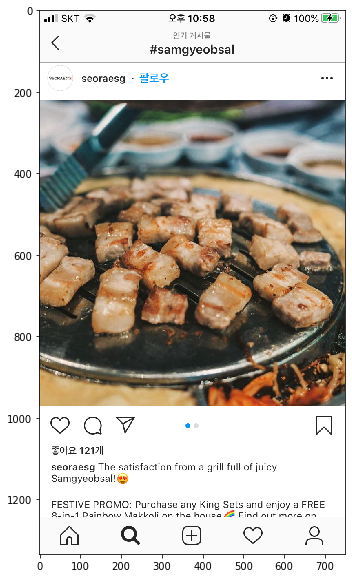

In [18]:
view_img('predict_img/', 'img1.png')
data = get_img_array('predict_img/img1.png')
predict_result(dense, data)

('삼겹살', 'Samgyeobsal')

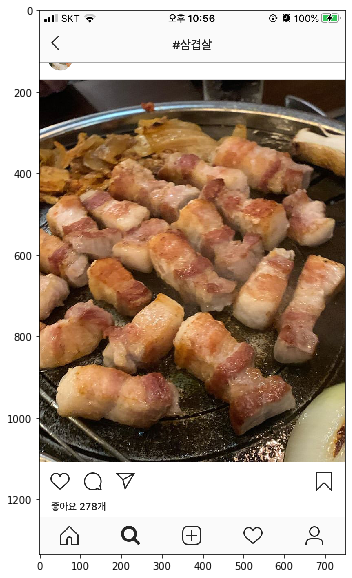

In [19]:
view_img('predict_img/', 'img2.png')
data = get_img_array('predict_img/img2.png')
predict_result(dense, data)

('짬뽕', 'Jjamppong')

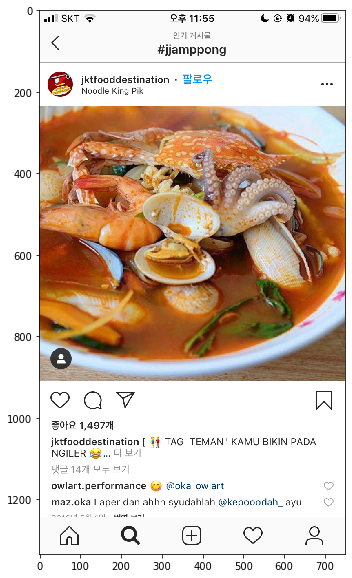

In [20]:
view_img('predict_img/', 'img3.png')
data = get_img_array('predict_img/img3.png')
predict_result(dense, data)

('짬뽕', 'Jjamppong')

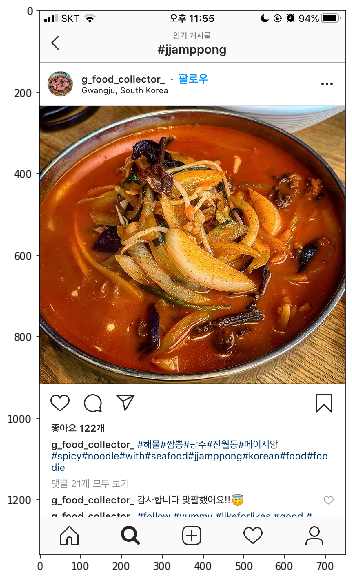

In [21]:
view_img('predict_img/', 'img4.png')
data = get_img_array('predict_img/img4.png')
predict_result(dense, data)

('짜장면', 'Jjajangmyeon')

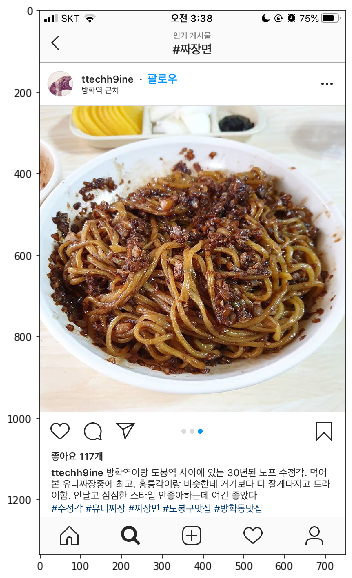

In [31]:
view_img('predict_img/', 'img5.png')
data = get_img_array('predict_img/img5.png')
predict_result(dense, data)

('곰탕_설렁탕', 'Gomtang_Seolleongtang')

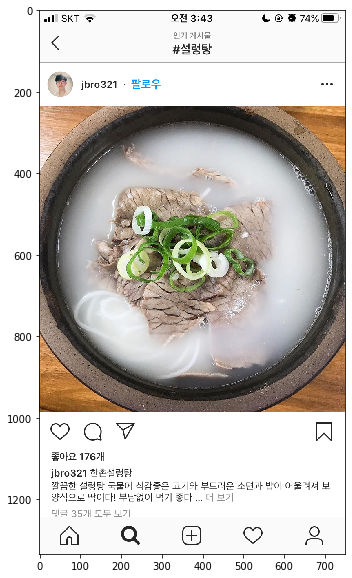

In [36]:
view_img('predict_img/', 'img6.png')
data = get_img_array('predict_img/img6.png')
predict_result(dense, data)

('짬뽕', 'Jjamppong')

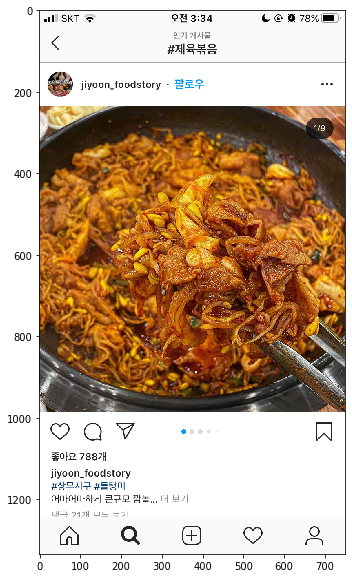

In [30]:
view_img('predict_img/false/', 'img5_.png')
data = get_img_array('predict_img/false/img5_.png')
predict_result(dense, data)

('짬뽕', 'Jjamppong')

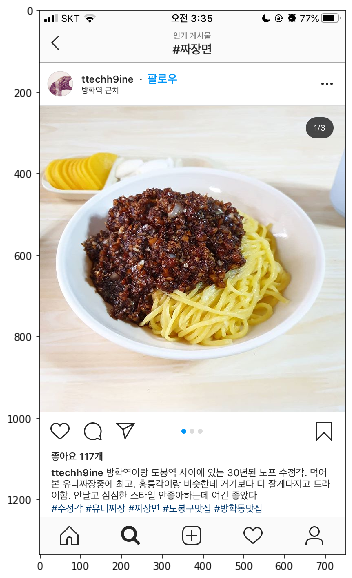

In [29]:
view_img('predict_img/false/', 'img6_.png')
data = get_img_array('predict_img/false/img6_.png')
predict_result(dense, data)

('삼겹살', 'Samgyeobsal')

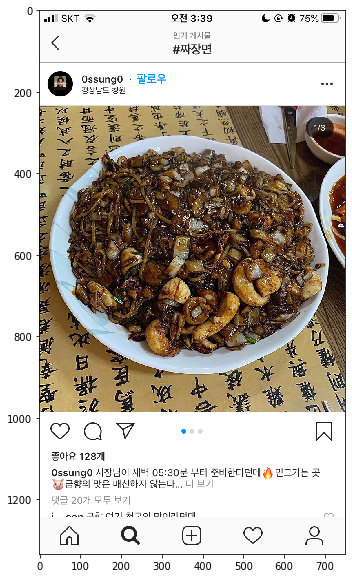

In [33]:
view_img('predict_img/false/', 'img8_.png')
data = get_img_array('predict_img/false/img8_.png')
predict_result(dense, data)

('삼겹살', 'Samgyeobsal')

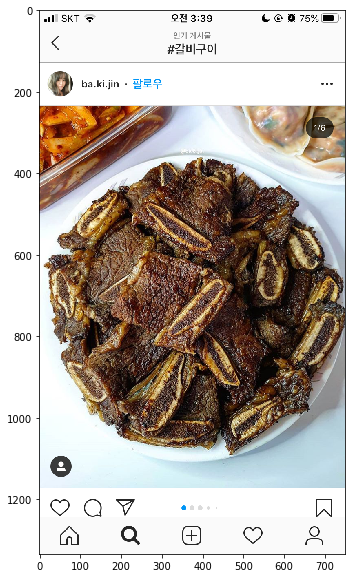

In [34]:
view_img('predict_img/false/', 'img9_.png')
data = get_img_array('predict_img/false/img9_.png')
predict_result(dense, data)

('삼겹살', 'Samgyeobsal')

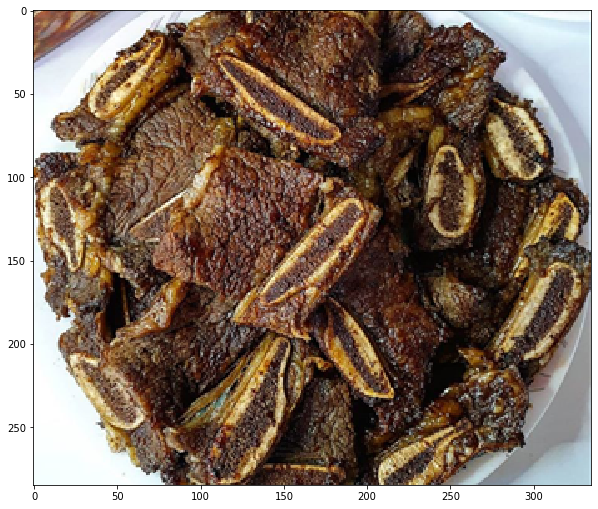

In [35]:
view_img('predict_img/false/', 'img9_closeup_.png')
data = get_img_array('predict_img/false/img9_closeup_.png')
predict_result(dense, data)

# DenseNet - Image size:128, Epoch:10

In [126]:
datagen = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True )

# hyperparameters
K = 32
init_ch = 64 # 가장 첫 layer의 채널 수 입니다.
compression = 0.5 # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5 사용

inp_shape = (128, 128, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)


def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)

        x = concatenate([x, tmp])

    return x


def transition_block(x):
    shape = x.get_shape().as_list() # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression) # compression 비율만큼 channel을 줄여 줍니다.

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))


input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)
x = dense_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

dense128 = Model(input_img, x)

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5',
                             save_best_only=True,
                             save_weights_only=True)

In [130]:
dense128.compile(optimizer=Adam(0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [108]:
## 사진 사이즈 변경해서 np array로 변경

image_folder = 'top10_food_test'
img_path = image_folder + '/'
image_size = 128

x_test_128 = []
y_test_128 = []

print('test 이미지 입력')

for i, food in enumerate(food_list):
    path = img_path + food  
    print(food, end = ',')

    files = []
    files.extend(glob.glob(path + '/*'))

    for file in files:
        img = Image.open(file)
        img = img.convert("RGB") # 색상 모드 변경
        img = img.resize((image_size, image_size)) # 이미지 크기 변경

        data = np.asarray(img)

        x_test_128.append(data)
        y_test_128.append(i)
        
print()

x_test_128 = np.asarray(x_test_128)
y_test_128 = np.asarray(y_test_128)

test 이미지 입력
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [109]:
x_test_128 = np.array(x_test_128) / 127.5 - 1

In [110]:
y_test_128 = y_test_128.reshape(-1, 1)

In [128]:
model_filename = "h_file/model_img_128.h5"
dense.load_weights(model_filename)

predicted = [np.argmax(i) for i in dense128.predict(x_test_128)]

In [132]:
score = dense128.evaluate(x_test_128, y_test_128)

100/100 [==============================] - 21s 212ms/sample - loss: 122.3629 - acc: 0.0800


In [133]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test_128[i][0]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test_128[i][0]], end='')
        
    if food_list[predicted[i]] == food_list[y_test_128[i][0]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

예측: 제육볶음		/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이
예측: 곰탕_설렁탕	/	실제 값: 갈비구이

예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 삼겹살		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 곰탕_설렁탕	/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 곰탕_설렁탕	/	실제 값: 제육볶음
예측: 곰탕_설렁탕	/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 곰탕_설렁탕	/	실제 값: 제육볶음

예측: 곰탕_설렁탕	/	실제 값: 짬뽕
예측: 삼겹살		/	실제 값: 짬뽕
예측: 삼겹살		/	실제 값: 짬뽕
예측: 곰탕_설렁탕	/	실제 값: 짬뽕
예측: 곰탕_설렁탕	/	실제 값: 짬뽕
예측: 삼겹살		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕
예측: 곰탕_설렁탕	/	실제 값: 짬뽕
예측: 곰탕_설렁탕	/	실제 값: 짬뽕
예측: 곰탕_설렁탕	/	실제 값: 짬뽕

예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 제육볶음		/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 곰탕_설렁탕	/	실제 값: 삼겹살

예측: 곰탕_설렁탕	/	실제 값: 짜장면
예측: 곰탕_설렁탕	/	실제 값: 짜장면
예측: 제육볶음	

## Densenet - Image:32, Epoch:5

In [134]:
datagen = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True )

# hyperparameters
K = 32
init_ch = 64 # 가장 첫 layer의 채널 수 입니다.
compression = 0.5 # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5 사용

inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)


def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)

        x = concatenate([x, tmp])

    return x


def transition_block(x):
    shape = x.get_shape().as_list() # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression) # compression 비율만큼 channel을 줄여 줍니다.

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))


input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)
x = dense_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

dense = Model(input_img, x)

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5',
                             save_best_only=True,
                             save_weights_only=True)

In [135]:
dense.compile(optimizer=Adam(0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [136]:
model_filename = "h_file/Densenet3_image32_epoch5.h5"
dense.load_weights(model_filename)

predicted = [np.argmax(i) for i in dense.predict(x_test)]

In [137]:
score = dense.evaluate(x_test, y_test_reshape)

100/100 [==============================] - 11s 110ms/sample - loss: 6.4335 - acc: 0.4700


In [138]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test[i]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test[i]], end='')
        
    if food_list[predicted[i]] == food_list[y_test[i]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 삼겹살		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 칼국수		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 삼겹살		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 삼겹살		/	실제 값: 갈비구이

예측: 갈비구이		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 갈비구이		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 삼겹살		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 갈비구이		/	실제 값: 제육볶음
예측: 갈비구이		/	실제 값: 제육볶음
예측: 갈비구이		/	실제 값: 제육볶음
예측: 짬뽕		/	실제 값: 제육볶음

예측: 갈비구이		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 훈제오리		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 칼국수		/	실제 값: 짬뽕
예측: 갈비구이		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕

예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 불고기		/	실제 값: 삼겹살
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 곰탕_설렁탕	/	실제 값: 삼겹살
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정